# Visualization of Data-Generator

In [84]:
# %load_ext autoreload
# %autoreload 2

In [166]:
from typing import Callable
from functools import partial

import jax
import jax.numpy as jnp

import flax
import flax.linen as nn

import matplotlib.pyplot as plt
import seaborn as sns

from functions import Fourier, Mixture, Slope, Polynomial, WhiteNoise, Shift

rng = jax.random.key(0)

## Define functions to sample datasets

Marginal distribution over datasets: $p(X, Y) = \int p(Y | X, Z) p(X | Z) p(Z) dZ$

The joint distribution $p(X, Y, Z)$ is built by a `function` module and a data-sampler. The function module first samples (Monte-Carlo) from $p(Z)$, the input sampler then samples $p(X | Z)$ with the provided sample $Z$

In [164]:
# Define the family of functions to be generated.
f1 = Fourier(n=4, amplitude=.5, period=1.0)
f2 = Fourier(n=2, amplitude=.5, period=1.0)
f3 = Fourier(n=6, amplitude=.5, period=2.0)

m = Mixture([Shift(f1, y_shift=-1), Shift(f2, y_shift=0.0), Shift(f3, y_shift=1.0)])
nm = Mixture([WhiteNoise(m.branches[0], 0.05), WhiteNoise(m.branches[1], 0.2), WhiteNoise(m.branches[2], 0.1)])

In [165]:
### Define joint-sampler

def joint(
    module: nn.Module, 
    data_sampler: Callable[
        [nn.Module, flax.typing.VariableDict, flax.typing.PRNGKey], 
        tuple[jax.Array, jax.Array]
    ],
    key: flax.typing.PRNGKey, 
    return_params: bool = False
) -> tuple[jax.Array, jax.Array]:
    # Samples from p(Z, X, Y)
    key_param, key_rng, key_data = jax.random.split(key, 3)
    
    params = module.init({'param': key_param, 'default': key_rng}, jnp.zeros(()))
    xs, ys = data_sampler(module, params, key_data)

    if return_params:
        return xs, ys, params
    return xs, ys


In [147]:
### Define data-samplers

def uniform(
    module: nn.Module, 
    params: flax.typing.VariableDict, 
    key: flax.typing.PRNGKey, 
    n: int,
    bounds: tuple[float, float]
) -> tuple[jax.Array, jax.Array]:
    
    # Samples from p(X, Y | Z) = p(Y | Z, X)p(X)
    key_xs, key_ys = jax.random.split(key)
    xs = jax.random.uniform(key_xs, (n,)) * (bounds[1] - bounds[0]) + bounds[0]

    ys = jax.vmap(module.apply, in_axes=(None, 0))(params, xs, rngs={'default': jax.random.split(key_ys, n)})

    return xs, ys


def chain(
    module: nn.Module, 
    params: flax.typing.VariableDict, 
    key: flax.typing.PRNGKey, 
    n: int,
    bounds: tuple[float, float]
) -> tuple[jax.Array, jax.Array]:
    
    # Samples from p(X, Y | Z) = prod_t p(Y_t | Z, X_t)p(X_t | Z, Y_<t, X_<t)
    
    key_x0, key_y0, key_batch = jax.random.split(key, 3)
    
    x0 = jax.random.uniform(key_x0, ()) * (bounds[1] - bounds[0]) + bounds[0]
    y0 = module.apply(params, x0, rngs={'default': key_y0})

    def body(carry, scanned):
        x_prev, y_prev = carry 
        key_in, key_out = jax.random.split(scanned)

        xt = jnp.square(jnp.sin(((x_prev - y_prev) * jnp.pi + jnp.abs(jax.random.normal(key_in) * 0.3)) / 5))
        xt = xt * (bounds[1] - bounds[0]) + bounds[0]
        
        yt = module.apply(params, xt, rngs={'default': key_out})

        return (xt, yt), (xt, yt)

    xs, ys = jax.lax.scan(body, (x0, y0), xs=jax.random.split(key_batch, n-1))[1]

    xs = jnp.concatenate([x0[None, ...], xs], -1)
    ys = jnp.concatenate([x0[None, ...], ys], -1)
    
    return xs, ys


def masked(
    module: nn.Module,
    params: flax.typing.VariableDict, 
    key: flax.typing.PRNGKey, 
    n: int, 
    bounds: tuple[float, float]
) -> tuple[jax.Array, jax.Array]:
    
    # Samples from p(X, Y | Z) = p(Y | Z, X)p(X)
    key_xs, key_ys, key_gap = jax.random.split(key, 3)

    gaps = jax.random.uniform(key_gap, (2,)) * (bounds[1] - bounds[0]) + bounds[0]
    low, high = gaps.min(), gaps.max()

    xs = jax.random.uniform(key_xs, (2, n // 2))
    xlow = xs[0] * (low - bounds[0]) + bounds[0]
    xhigh = xs[1] * (bounds[1] - high) + high

    xs = jnp.concatenate([xlow, xhigh], -1)
    ys = jax.vmap(module.apply, in_axes=(None, 0))(params, xs, rngs={'default': jax.random.split(key_ys, n)})

    return xs, ys
    

# Uniform Input Distribution

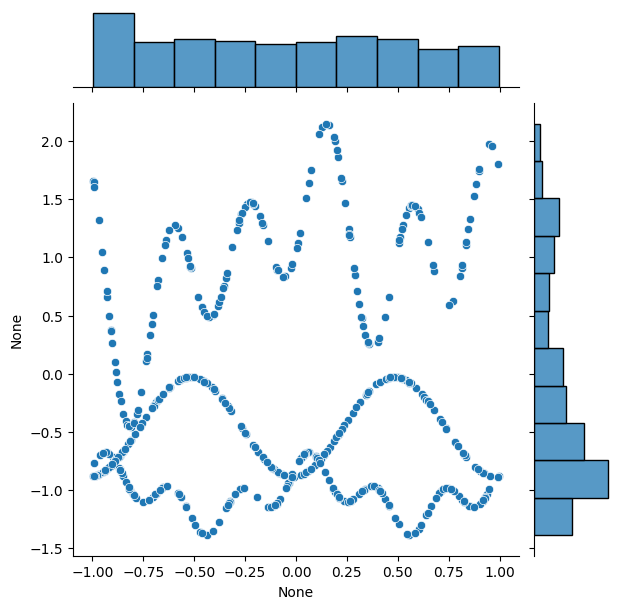

In [148]:
rng, key = jax.random.split(rng)
xs, ys = joint(m, partial(uniform, n=500, bounds=(-1, 1)), key)
sns.jointplot(x=xs, y=ys)

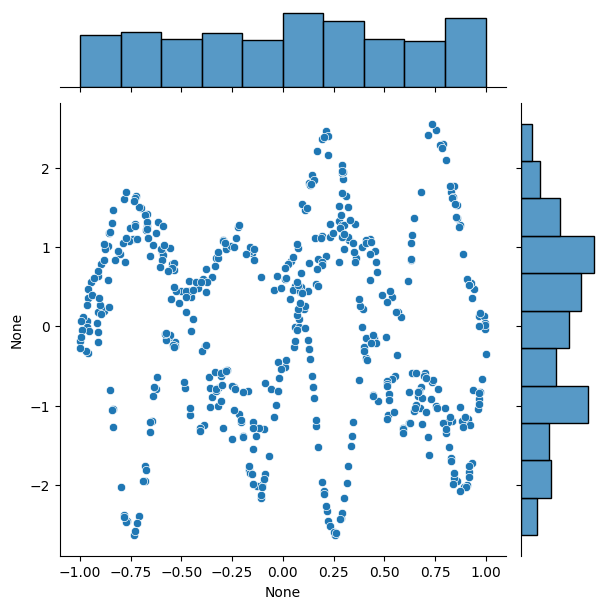

In [149]:
rng, key = jax.random.split(rng)
xs, ys = joint(nm, partial(uniform, n=500, bounds=(-1, 1)), key)
sns.jointplot(x=xs, y=ys)

# Chain Input Distribution

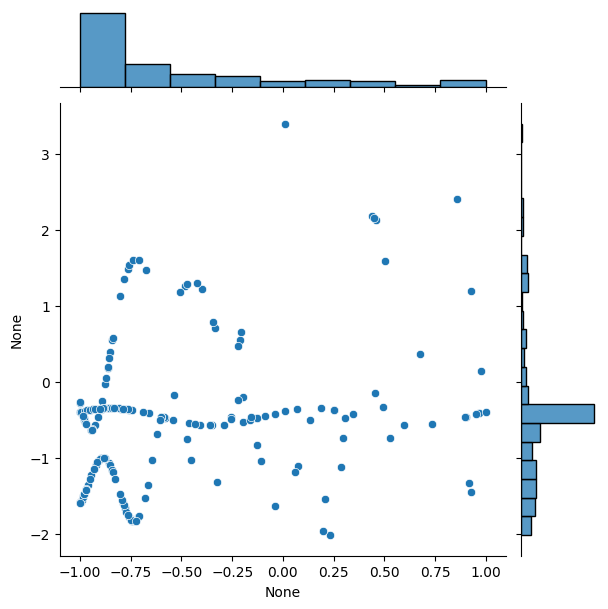

In [150]:
rng, key = jax.random.split(rng)
xs, ys = joint(m, partial(chain, n=200, bounds=(-1, 1)), key)
sns.jointplot(x=xs, y=ys)

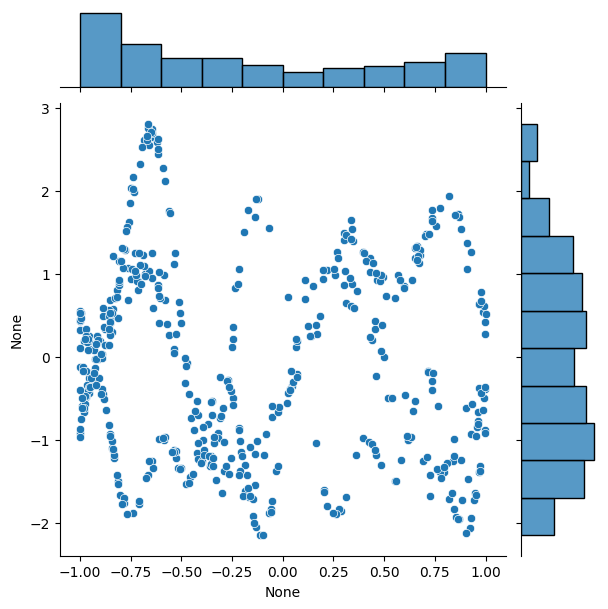

In [151]:
rng, key = jax.random.split(rng)
xs, ys = joint(nm, partial(chain, n=500, bounds=(-1, 1)), key)
sns.jointplot(x=xs, y=ys)

# Masked + Uniform Input Distribution

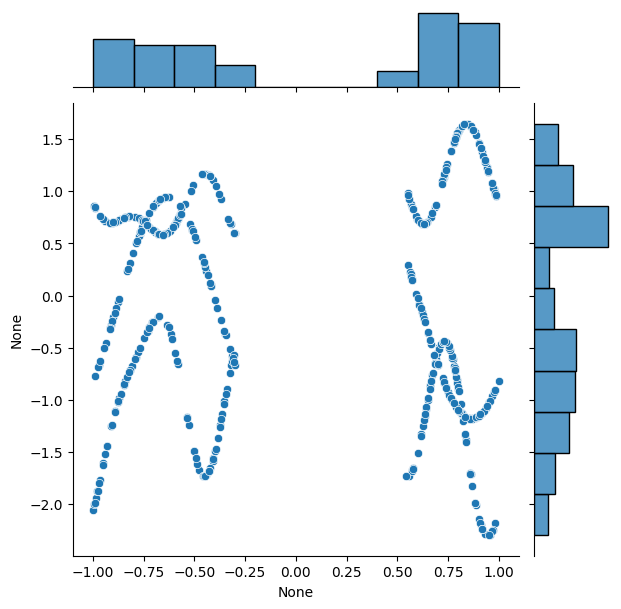

In [160]:
rng, key = jax.random.split(rng)
xs, ys = joint(m, partial(masked, n=500, bounds=(-1, 1)), key)
sns.jointplot(x=xs, y=ys)

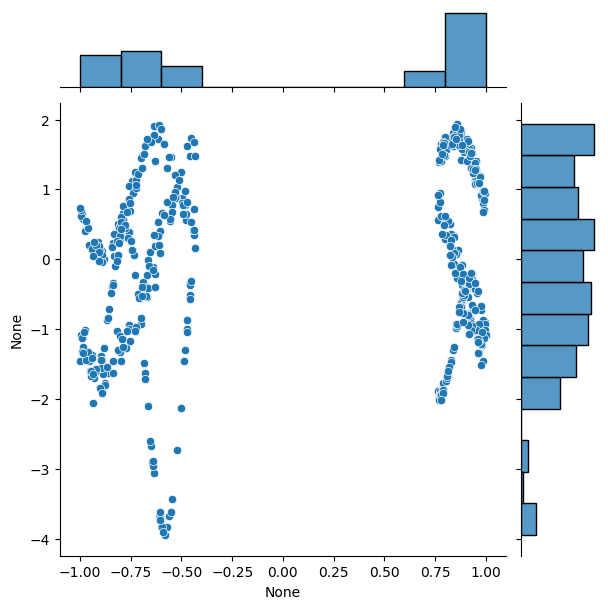

In [162]:
rng, key = jax.random.split(rng)
xs, ys = joint(nm, partial(masked, n=500, bounds=(-1, 1)), key)
sns.jointplot(x=xs, y=ys)